# Image Recognition with PCA - Lab

## Introduction

In this lab, you'll explore the classic MNIST dataset of handwritten digits. While not as large as the previous dataset on facial image recognition, it still provides a 64-dimensional dataset that is ripe for feature reduction.

## Objectives

In this lab you will: 

- Use PCA to discover the principal components with images 
- Use the principal components of  a dataset as features in a machine learning model 
- Calculate the time savings and performance gains of layering in PCA as a preprocessing step in machine learning pipelines 

## Load the data

Load the `load_digits` dataset from the `datasets` module of scikit-learn. 

In [1]:
# Load the dataset
from sklearn.datasets import load_digits

data = load_digits()
print(data.data.shape, data.target.shape)
dir(data)

(1797, 64) (1797,)


['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

## Preview the dataset

Now that the dataset is loaded, display the first 20 images.

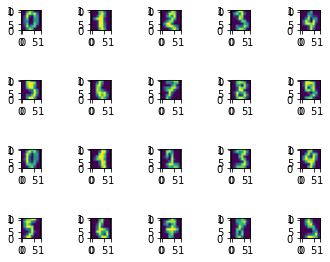

In [2]:
# Display the first 20 images 

import matplotlib.pyplot as plt
%matplotlib inline

r_w = 5
r_h = 1
c_n = 5
r_n = 4
fig = plt.figure(figsize=(r_w, r_h*r_n))
axes = fig.subplots(r_n, c_n)
for index, img in enumerate(data.images[:20]):
    ax = fig.add_subplot(r_n, c_n, index+1)
    ax.imshow(img)
fig.tight_layout()
plt.show()

## Baseline model

Now it's time to fit an initial baseline model. 

- Split the data into training and test sets. Set `random_state=22` 
- Fit a support vector machine to the dataset. Set `gamma='auto'` 
- Record the training time 
- Print the training and test accucary of the model 

In [3]:
# Split the data
from sklearn.model_selection import train_test_split

X = data.data
print(f"features:\n{data.feature_names}\n\n")

y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

features:
['pixel_0_0', 'pixel_0_1', 'pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_0_6', 'pixel_0_7', 'pixel_1_0', 'pixel_1_1', 'pixel_1_2', 'pixel_1_3', 'pixel_1_4', 'pixel_1_5', 'pixel_1_6', 'pixel_1_7', 'pixel_2_0', 'pixel_2_1', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5', 'pixel_2_6', 'pixel_2_7', 'pixel_3_0', 'pixel_3_1', 'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_3_6', 'pixel_3_7', 'pixel_4_0', 'pixel_4_1', 'pixel_4_2', 'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_4_6', 'pixel_4_7', 'pixel_5_0', 'pixel_5_1', 'pixel_5_2', 'pixel_5_3', 'pixel_5_4', 'pixel_5_5', 'pixel_5_6', 'pixel_5_7', 'pixel_6_0', 'pixel_6_1', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4', 'pixel_6_5', 'pixel_6_6', 'pixel_6_7', 'pixel_7_0', 'pixel_7_1', 'pixel_7_2', 'pixel_7_3', 'pixel_7_4', 'pixel_7_5', 'pixel_7_6', 'pixel_7_7']


(1347, 64) (450, 64) (1347,) (450,)


In [4]:
# Fit a naive model
from sklearn import svm

clf = svm.SVC(gamma='auto')
%timeit clf.fit(X_train, y_train)

354 ms ± 14.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Training and test accuracy
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print('Training Accuracy: {}\nTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0
Testing Accuracy: 0.58


### Grid search baseline

Refine the initial model by performing a grid search to tune the hyperparameters. The two most important parameters to adjust are `'C'` and `'gamma'`. Once again, be sure to record the training time as well as the training and test accuracy.

In [6]:
# Your code here
# ⏰ Your code may take several minutes to run

import numpy as np
from sklearn.model_selection import GridSearchCV

clf = svm.SVC()
param_grid = {
    'C' : np.linspace(.1, 10, num=11),
    'gamma' : np.linspace(10**-3, 5, num=11)
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
%timeit grid_search.fit(X_train, y_train)

31.6 s ± 923 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
# Print the best parameters 
grid_search.best_params_

{'C': 2.08, 'gamma': 0.001}

In [8]:
# Print the training and test accuracy 
train_acc = grid_search.best_estimator_.score(X_train, y_train)
test_acc = grid_search.best_estimator_.score(X_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9911111111111112


## Compressing with PCA

Now that you've fit a baseline classifier, it's time to explore the impacts of using PCA as a preprocessing technique. To start, perform PCA on `X_train`. (Be sure to only fit PCA to `X_train`; you don't want to leak any information from the test set.) Also, don't reduce the number of features quite yet. You'll determine the number of features needed to account for 95% of the overall variance momentarily.

In [9]:
# Your code here
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X_train)

## Plot the explained variance versus the number of features

In order to determine the number of features you wish to reduce the dataset to, it is sensible to plot the overall variance accounted for by the first $n$ principal components. Create a graph of the variance explained versus the number of principal components.

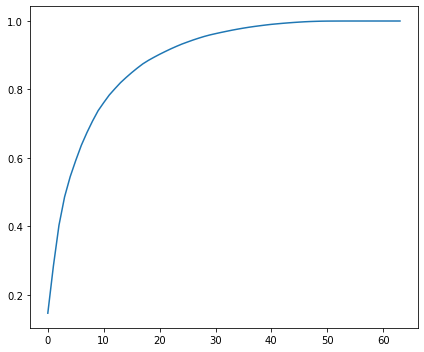

In [10]:
# Your code here
# print(len(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(6,5))
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_.cumsum())
fig.tight_layout()
plt.show()

## Determine the number of features to capture 95% of the variance

Great! Now determine the number of features needed to capture 95% of the dataset's overall variance.

In [11]:
# Your code here
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 29	Total Variance Explained: 0.9549611953216072


## Subset the dataset to these principal components which capture 95% of the overall variance

Use your knowledge to reproject the dataset into a lower-dimensional space using PCA. 

In [12]:
# Your code here
pca = PCA(n_components=n_to_reach_95)
X_pca_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_.cumsum()[-1]

0.9549588310756773

## Refit a model on the compressed dataset

Now, refit a classification model to the compressed dataset. Be sure to time the required training time, as well as the test and training accuracy.

In [13]:
# Your code here
clf = svm.SVC(gamma='auto')
%timeit clf.fit(X_pca_train, y_train)
train_pca_acc = clf.score(X_pca_train, y_train)

X_pca_test = pca.transform(X_test)
test_pca_acc = clf.score(X_pca_test, y_test)

print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_pca_acc, test_pca_acc))

202 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Training Accuracy: 1.0	Testing Accuracy: 0.14888888888888888


### Grid search

Finally, use grid search to find optimal hyperparameters for the classifier on the reduced dataset. Be sure to record the time required to fit the model, the optimal hyperparameters and the test and train accuracy of the resulting model.

In [14]:
# Your code here
# ⏰ Your code may take several minutes to run
clf = svm.SVC()
param_grid = {
    'C' : np.linspace(.1, 10, num=11),
    'gamma' : np.linspace(10**-3, 5, num=11)
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
%timeit grid_search.fit(X_pca_train, y_train)

20.2 s ± 946 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# Print the best parameters 
grid_search.best_params_

{'C': 3.07, 'gamma': 0.001}

In [16]:
# Print the training and test accuracy 
train_acc = grid_search.best_estimator_.score(X_pca_train, y_train)
test_acc = grid_search.best_estimator_.score(X_pca_test, y_test)
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9933333333333333


## Summary

Well done! In this lab, you employed PCA to reduce a high dimensional dataset. With this, you observed the potential cost benefits required to train a model and performance gains of the model itself.